In [147]:
import numpy as np
import matplotlib.pyplot as plt

In [148]:
# Main system parameters: number of mics, number of samples in time
Nmics = 64
Nsamp = 200

# Source: x,y coordinates: x: 0+, y: [-Y, +Y] where Y determined by
src = (0,0)

# Spacing between microphones
pitch = 0.1
# proxy for sampling rate
dist_per_samp = 0.1

#Locations of microphones
mics = [0]*Nmics
#Even no. of mics
if Nmics%2 == 0: 
    y = -(pitch*Nmics)/2
    for i in range(int(Nmics/2)):
        mics[i] = y + i*pitch
    for i in range(int(Nmics/2),Nmics):
        mics[i] = -mics[Nmics-1-i]
#Odd no. of mics
else:
    mics[int((Nmics-1)/2)] = 0.0
    y = -(pitch*(Nmics-1))/2
    for i in range(int((Nmics-1)/2)):
        mics[i] = y + i*pitch
    for i in range(int((Nmics+1)/2),Nmics):
        mics[i] = -mics[Nmics-1-i]
        
# Location of point obstacle
obstacle = (3, -1)

## Question

### The plots below show two example sinc pulses. How will you generate pulses that look like this? Which parameter should be changed? What effect do you think this will have on the final image?
We use the numpy.sinc function to generate the waveforms. The parameter to be changed is **SincP**. This acts like the frequency of the waveform, the higher the value the more compressed the wave and the lower the value the wider the wave.

2. The higher the value of **SincP** the sharper the final image.

In [149]:
# Speed of sound in the medium
C = 0.5
# Time dilation factor for sinc pulse: how narrow
SincP = 1.0

def wsrc(t):
    return np.sinc(SincP*t)

t = 0
time = []
wave = []
for i in range(Nsamp):
    time.append(t)
    wave.append(wsrc(t))
    t = ((i+1)*dist_per_samp)/C
    
time = np.array(time)
wave = np.array(wave)

plt.clf()
plt.plot(time,wave)

In [150]:
def dist(src, pt, mic):
    d1 = (pow((src[0] - pt[0]),2) + pow((src[1] - pt[1]),2))**0.5  # CODE distance from src to pt
    d2 = (pow((mic[0] - pt[0]),2) + pow((mic[1] - pt[1]),2))**0.5 # CODE distance from pt to mic
    return d1 + d2

# Setting up MIC outputs

This section is where I setup the mic outputs for a particular source and obstacle.

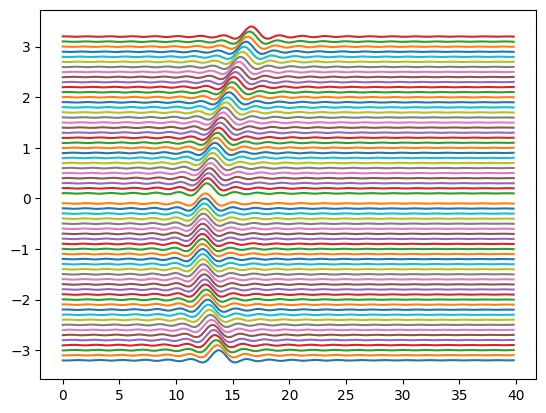

In [151]:
# Generating Mic Outputs
plt.clf()
mic_op = []
for i in range(Nmics):
    del_t = dist(src,obstacle,(0,mics[i]))/C
    op = []
    time = []
    t = 0
    for j in range(Nsamp):
        op.append(wsrc(t - del_t)*0.2)
        time.append(t)
        t = ((j+1)*dist_per_samp)/C 
        
        
    time = np.array(time)
    mic_op.append(op)
    op = np.array(op)
    op = op + mics[i]

    plt.plot(time,op)
    
mic_op = np.array(mic_op)
plt.show()
        
        

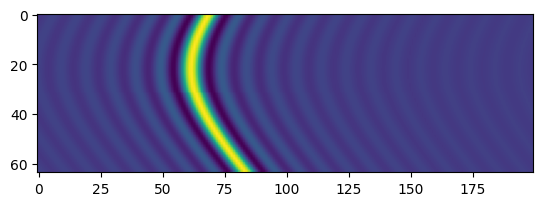

In [152]:
plt.imshow(mic_op)

# Reconstruction Using DAS algorithm

This section deaks with the reconstruction of the image using the delay and sum algorithm. Code for this is given below

## Question
### - Does it make sense to reconstruct up to Nsamp? What value is more reasonable as an upper limit for the x-axis here?

- Answer :
I have plotted distance on the X-axis for the reconstructed plot. All mics have sampled outputs only for distance less than (dist_per_sample x Nsamp), so any point beyond X = (dist_per_sample x Nsamp)/2, will not have a corresponding mic output, therefore Nsamp/2 seems like a more appropriate limit.

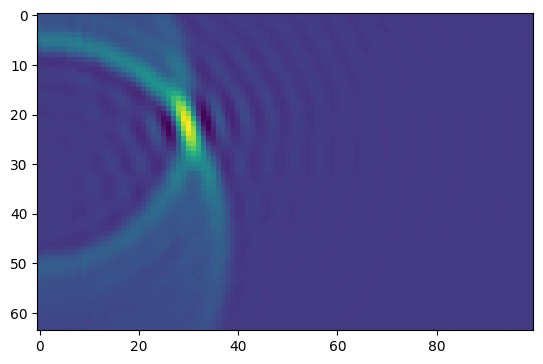

In [153]:
htmap = np.zeros((Nmics,int(Nsamp/2)))
for i in range(int(Nsamp/2)):
    for j in range(Nmics):
        val = 0
        pt = (i*dist_per_samp,mics[j])
        for k in range(Nmics):
            delay = dist(src,pt,(0,mics[k]))/C
            # print(delay)
            for q in  range(len(time)):
                if time[q] >= delay :
                    t_idx = q
                    break
            val += mic_op[k][t_idx]
            htmap[j][i] = val

plt.imshow(htmap)
            

## Question
### - The (x, y) coordinates corresponding to the maximum amplitude (yellowcolour) is approximately
(30, 22). Explain why this is the correct expected position for the given obstacle.
- The (x,y) coordinates on the heatmap represent the corresponding positions in my ht-map matrix. The point 30, corresponds to the point that has the X coordinate dist_per_sample*30 = 30 x 0.1 = 3, while the 22 represents the position of the 23rd mic, which is at -3.2 + (22 x 0.1) = -1. Thus the obstacle is found at (3,-1).

### - What is the maximum obstacle x- and y- coordinate that you can use and still have an image reconstructed?

- The co-ordinates of the obstacle should be such that (**distance from source to obstacle**) + (**distance from obstacle to point**) should be less than Nsamp*dist_per_samp.

### - What happens if C is different - if C is decreased it looks like the image becomes sharper. Can you explain why intuitively?
 - If the value of **C** is decreased for the same Nsamp, dist_per_samp values, the range of the sampled times is higher and higher the ranger of the sampled times, the sharper the image you obtain.

 ### - What happens if Nmics is increased or decreased? Do the experiments with Nmics = [8, 32, 64] and Nsamp = [50, 100, 200] (all combinations). Attach the resulting images.

 - The higher the value of Nmics the higher, the clearer the image.



In [154]:
def heatmap(file):
    f = open(file)
    data = np.loadtxt(f)
    htmap = np.zeros((Nmics,int(Nsamp/2)))
    for i in range(Nsamp):
        for j in range(Nmics):
            val = 0
            pt = (i*dist_per_samp,mics[j])
            for k in range(Nmics):
                delay = dist(src,pt,(0,mics[k]))/C
                # print(delay)
                for t in  time:
                    if t >= delay :
                        samp_time = t
                        break
                t_idx = np.where(time == samp_time)
                val += data[k][t_idx[0][0]]
                htmap[j][i] = val

    plt.imshow(htmap)

In [155]:
# heatmap('rx2.txt')

In [156]:
# heatmap('rx3.txt')